In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import cell_decomp_func as cdfn


# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
%load_ext autoreload
sys.version

'3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]'

In [6]:
dataset = 'data1'
## Load simulated data from R
spots_st = adfn.return_files(s_data, 'spatial_transcriptomics/simulate_10x_spots/' + dataset + '/', '*simulated_spots*')[0]
props_st = adfn.return_files(s_data, 'spatial_transcriptomics/simulate_10x_spots/' + dataset + '/', '*true*')[0]
ref_st = adfn.return_files(s_data, 'spatial_transcriptomics/simulate_10x_spots/'  + dataset + '/', '*ref*')[0]
de_st = pd.read_csv(s_data + 'spatial_transcriptomics/simulate_10x_spots/de_genes.csv')
spots_st, props_st, ref_st

('simulated_spots.csv', 'true_weights.csv', 'reference.csv')

In [7]:
def load(spots_st, props_st, ref_st):
    spots = pd.read_csv(spots_st)
    prop_vec = pd.read_csv(props_st).T
    prop_vec = np.asarray(prop_vec.drop(prop_vec.index[0]))
    prop_vec = np.float64(prop_vec)
    ref_exp = pd.read_csv(ref_st)

    #Find DE genes
    degene_l = np.array(de_st['gene']) 
    ind=[]
    for de in degene_l:
        ind = np.append(ind, np.where(spots['gene'] == de)[0][0])

    #Keep only DE genes
    spots = spots.iloc[ind].T
    spots = np.asarray(spots.drop(spots.index[0]))
    spots = np.float64(spots)
    ref_exp = ref_exp.iloc[ind].T
    ref_exp = np.asarray(ref_exp.drop(ref_exp.index[0]))
    ref_exp = (ref_exp/np.reshape(np.sum(ref_exp, axis=1), (ref_exp.shape[0],1))) #convert to a rate
    ref_exp = np.float64(ref_exp)
    return(ref_exp, spots, prop_vec)

In [8]:
top_cells = 9
top_genes = 500
top_spots = 50


ref_exp, spots, prop_vec = load(spots_st, props_st, ref_st)
#+++++++++++++++++
spots = spots[:top_spots,:top_genes]
ref_exp = ref_exp[:top_cells, :top_genes]
prop_vec = prop_vec[:top_spots,:top_cells]
n_clusts = ref_exp.shape[0]
n_spots = spots.shape[0]
n_genes = spots.shape[1]

In [9]:
# Run basic model
start_time = time.time()
#Define parameters of simulated data
noise_type = 'gaussian' 

model = cdfn.basic_pymc(n_clusts, n_spots, n_genes, ref_exp, spots, noise_type=noise_type, likelihood = 'poisson') #CHANGE!
with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)


Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 64 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [10]:
r2

0.6558807620322039

In [13]:
r2

0.08354435416491245

In [12]:
k=5
clf=PCA(k)
zero_data = (ref_exp - np.mean(ref_exp,axis=0))
X_train=zero_data
ref_exp=clf.fit_transform(X_train)
comp = clf.components_
spots = np.dot(spots, comp.T)

n_genes=k


with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes) }) as model:
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
    #Likelihood of observed data given Poisson rates
    y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)

Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 29 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [5]:
r_list

[0.02717099610767738,
 0.004482790152188174,
 0.0055235260728611095,
 0.0006141565269829441,
 0.035661908747950236,
 0.020752311038979194,
 0.004295053373358592,
 0.005994636536466717,
 0.029260505561426172,
 0.01483006896898551]

In [128]:
# Run alpha noise
import time
r_list = list(range(5))
for r in range(5):
    #Set default parameters
    n_clusts = 5
    n_genes = 500
    n_cells = 100
    rate_range = 0,40 #max and min of uniform distribution for generating rates
    noise_type = 'exponential' #CHANGE!

    start_time = time.time()
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']
    prop_vec = spot_sim.__dict__['prop_vec']
    spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!

    #n_genes=k
    #Simple Linear regression
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes) }) as model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
        lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
        #Likelihood of observed data given Poisson rates
        y=pm.Poisson("y", mu=lmd*N_g, observed=spots)
    with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
    post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
    r_list[r] = r2



Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 21 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [129]:
r_list

[0.9711107742362823,
 0.9502444465651422,
 0.9604177756785343,
 0.9627801040866872,
 0.9590196287069342]

In [24]:
par_list = np.linspace(0.1,1, 10)
par_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [31]:
# Run alpha noise
import time
r_list = list(range(len(par_list)))
for x,p in enumerate(par_list):

    #Set default parameters
    n_clusts = 5
    n_genes = 500
    n_cells = 100
    rate_range = 0,40 #max and min of uniform distribution for generating rates
    noise_type = 'exponential' #CHANGE!

    start_time = time.time()
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']

    eigval, eigvec = adfn.eigendecomposition(ref_exp)
    k = int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
    ref_exp = adfn.pca(ref_exp, k)
    prop_vec = spot_sim.__dict__['prop_vec']
    spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
    spots = np.dot(spots, eigvec[:,:k])

    n_genes=k
    #Simple Linear regression
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes) }) as model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
        lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
        #Likelihood of observed data given Poisson rates
        y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
    with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
    post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
    print(p)
    r_list[x] = r2



Sampling 1 chain for 632 tune and 0 draw iterations (632 + 0 draws total) took 15 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (632) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AttributeError: 'InferenceData' object has no attribute 'posterior'

In [30]:
r_list

[0.29572694811865474, 1, 2, 3, 4, 5, 6, 7, 8, 9]

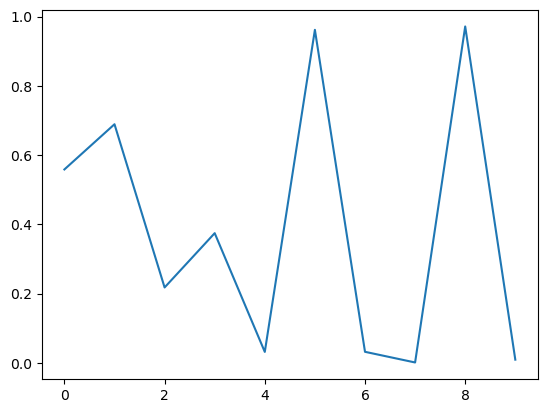

In [28]:
plt.plot(r_list)
plt.show()

In [3]:
# START
import time

#Set default parameters
n_clusts = 5
n_genes = 500
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
noise_type = 'exponential' #CHANGE!

start_time = time.time()
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)


Loaded parameters: 5 cell types , 100 cells, & 500 genes.
Created spot mixtures from simulated data: 36 spots.


In [9]:
from sklearn.decomposition import PCA
def prac_pca(data, k):
    zero_data = (data - np.mean(data,axis=0)) #zero centre across columns 
    cov=np.cov(zero_data, rowvar=False) #covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:,idx]
    eigenvalues = eigenvalues[idx]
    P = eigenvectors[:,:k]
    Z = np.dot(zero_data, P[:,:k]) #projected data with top n components
    return(Z,P)

In [87]:
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']
ref_exp = spot_sim.__dict__['mean_exps']

clf=PCA(k)
zero_data = (ref_exp - np.mean(ref_exp,axis=0))
X_train=zero_data
p_=clf.fit_transform(X_train)

In [ ]:
k=5
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']
ref_exp = spot_sim.__dict__['mean_exps']

d_,P = prac_pca(ref_exp, k)

In [104]:
n_genes, k

(500, 500)

In [105]:
ref_exp.shape

(5, 5)

In [116]:
n_clusts = 5
n_genes = 500
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
noise_type = 'exponential' #CHANGE!
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
k=5
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']

ref_exp = spot_sim.__dict__['mean_exps']
ref_exp,P = prac_pca(ref_exp, k)
#k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
#spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
spots = np.dot(spots, P[:,:k])

Loaded parameters: 5 cell types , 100 cells, & 500 genes.
Created spot mixtures from simulated data: 35 spots.


In [117]:
P

array([[ 0.01822071,  0.04116699,  0.04245535, -0.07023481,  0.        ],
       [-0.1020447 , -0.06436936, -0.07462476,  0.00201682, -0.03361944],
       [ 0.03500345,  0.01787433, -0.04039716,  0.00831274, -0.06773532],
       ...,
       [ 0.05305854, -0.02707004,  0.08673854,  0.03973025, -0.06957425],
       [ 0.03023316,  0.05932194,  0.01533157, -0.00397096, -0.04460518],
       [-0.03662041,  0.03598287, -0.07645897, -0.00572623, -0.01984369]])

In [115]:
ref_exp

array([[ 2.07449803e-03, -4.44617576e-04,  1.65275311e-02,
        -1.45819576e-02,  2.59948098e-18],
       [ 1.66951746e-04, -1.51549530e-02,  6.85795791e-03,
         1.54399794e-02,  2.59948098e-18],
       [ 2.05647776e-02, -2.92604708e-04, -1.25655424e-02,
        -2.83568715e-03,  2.59948098e-18],
       [-4.39924221e-03,  2.15592827e-02,  1.70003900e-03,
         8.73735646e-03,  2.59948098e-18],
       [-1.84069852e-02, -5.66710736e-03, -1.25199856e-02,
        -6.75969109e-03,  2.59948098e-18]])

In [106]:
#spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
r_list = list(range(5))

for r in range(5):
    n_clusts = 5
    n_genes = 500
    n_cells = 100
    rate_range = 0,40 #max and min of uniform distribution for generating rates
    noise_type = 'exponential' #CHANGE!
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
    k=5
    #MINE
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    prop_vec = spot_sim.__dict__['prop_vec']

    ref_exp = spot_sim.__dict__['mean_exps']
    ref_exp,P = prac_pca(ref_exp, k)ß
    #k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
    #spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
    spots = np.dot(spots, P[:,:k])

    n_genes=k
    #Simple Linear regression
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes) }) as model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
        lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
        #Likelihood of observed data given Poisson rates
        y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
    with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
    post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)

    r_list[r] = r2

Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 56 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [107]:
r_list

[0.15505774081101478,
 0.0682512476344604,
 0.33537843801162665,
 0.07718285364119361,
 0.09418066240738168]

In [101]:
r_list, k

([0.15482789045471781,
  0.45775298564173905,
  0.07028221759897903,
  0.194432529768374,
  0.0939605572312131],
 5)

array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

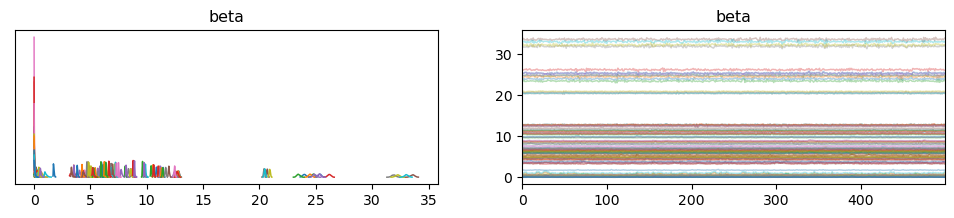

In [278]:
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(data.posterior['beta'])

array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

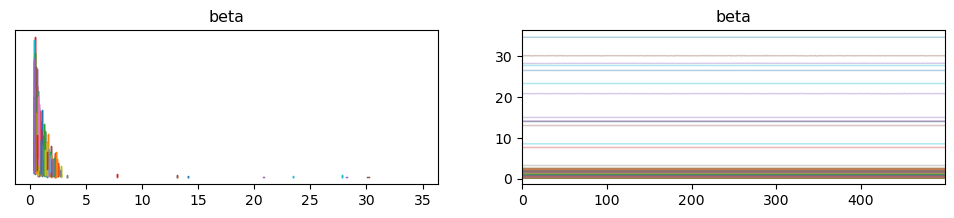

In [54]:
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(data.posterior['beta'])

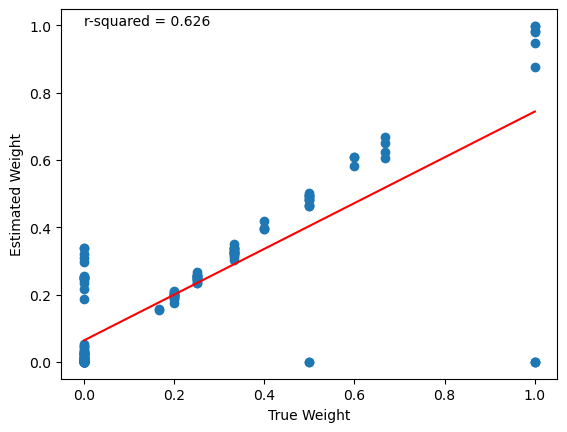

In [282]:
#Check performance
from scipy.stats import linregress

mean_post=post

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

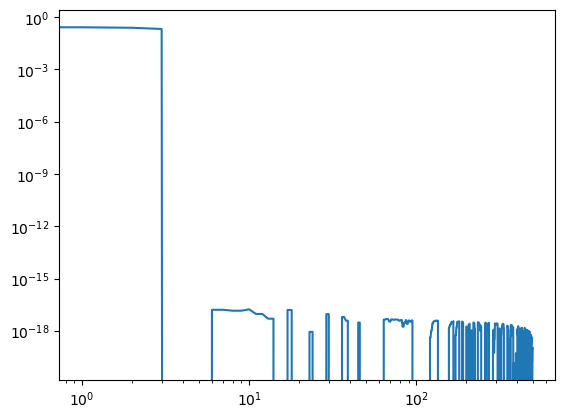

In [18]:
plt.plot((eigval/np.sum(eigval)))
plt.loglog()
plt.show()

In [9]:
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
r2

0.9457399155739533

In [11]:
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
r2

0.12205650393164945

In [18]:
clust_list = np.linspace(3, 30, 7).astype(int)
genes_list = np.linspace(100, 3000, 7).astype(int)
cells_list = np.linspace(100, 3000, 7).astype(int)
list_list = [clust_list, genes_list, cells_list]
mode_list= ['nclusts', 'ngenes', 'nspots']

In [108]:
# Run alpha noise
import time

model_type = 'alpha-pca' #CHANGE!

for x,li in enumerate(list_list):
    mode = mode_list[x]

    for l in li:
        #Set default parameters
        n_clusts = 5
        n_genes = 800
        n_cells = 100
        if mode == 'nclusts':
            n_clusts = l
        if mode == 'ngenes':
            n_genes = l
        if mode == 'nspots':
            n_cells=l

        rate_range = 0,40 #max and min of uniform distribution for generating rates
        noise_type = 'exponential' #CHANGE!

        start_time = time.time()
        #Simulate spot data from simulated gene expression
        spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
        n_spots = spot_sim.__dict__['n_spots']
        spots = spot_sim.__dict__['spots']
        ref_exp = spot_sim.__dict__['mean_exps']
        eigval, eigvec = adfn.eigendecomposition(ref_exp)
        k = sum((eigval/np.sum(eigval)) > 0.05) 
        ref_exp = adfn.pca(ref_exp, k)
        prop_vec = spot_sim.__dict__['prop_vec']
        spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
        spots = np.dot(spots, eigvec[:,:k])

        with pm.Model(coords={"celltypes": np.arange(n_clusts),
                            "spots": np.arange(n_spots),
                            "genes": np.arange(n_genes),
                            "1": np.arange(1) }) as model:
            #Declare data 
            mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
            # Priors for unknown model parameters
            beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes']) # celltype proportions

            if noise_type == 'gaussian': alpha = pm.Normal("alpha",mu=0, sigma=1, dims=['spots','1'])
            if noise_type == 'exponential': alpha = pm.Exponential("alpha", lam=1, dims=['spots','1']) # random noise at each spot and gene

            lmd= pm.Deterministic('lmd', np.exp(alpha)*pm.math.dot(beta, mean_exp), dims=['spots','genes'])
            #Convert from proportions to counts
            N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

            #Likelihood of observed data given Poisson rates
            y=pm.Normal("y", mu=lmd*N_g, observed=spots)

        with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

        post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
        if len(str(l))<2:pref = '000' + str(l)
        elif len(str(l))<3:pref = '00' + str(l)
        elif len(str(l))<4:pref = '0' + str(l)
        else:pref= str(l)
        fin = (time.time() - start_time)

        np.save(s_data + 'spatial_transcriptomics/RCTD-test_noise-' + noise_type + '_model-' + model_type + '_' + mode + '-' + pref + '.npy', np.array([prop_vec, post, r2, fin], dtype=object))
        print(l)


Loaded parameters: 3 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 36 spots.


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [96]:
# Run alpha noise
import time

model_type = 'gamma-pca' #CHANGE!

for x,li in enumerate(list_list):
    mode = mode_list[x]

    for l in li:
        #Set default parameters
        n_clusts = 5
        n_genes = 800
        n_cells = 100
        if mode == 'nclusts':
            n_clusts = l
        if mode == 'ngenes':
            n_genes = l
        if mode == 'nspots':
            n_cells=l

        rate_range = 0,40 #max and min of uniform distribution for generating rates
        noise_type = 'exponential' #CHANGE!

        start_time = time.time()
        #Simulate spot data from simulated gene expression
        spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
        n_spots = spot_sim.__dict__['n_spots']
        spots = spot_sim.__dict__['spots']
        ref_exp = spot_sim.__dict__['mean_exps']
        eigval, eigvec = adfn.eigendecomposition(ref_exp)
        k = sum((eigval/np.sum(eigval)) > 0.05) 
        ref_exp = adfn.pca(ref_exp, k)
        prop_vec = spot_sim.__dict__['prop_vec']
        spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
        spots = np.dot(spots, eigvec[:,:k])

        model = cdfn.gamma_pymc(n_clusts, n_spots, k, ref_exp, spots, noise_type=noise_type) #CHANGE!
        with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

        post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
        if len(str(l))<2:pref = '000' + str(l)
        elif len(str(l))<3:pref = '00' + str(l)
        elif len(str(l))<4:pref = '0' + str(l)
        else:pref= str(l)
        fin = (time.time() - start_time)

        np.save(s_data + 'spatial_transcriptomics/RCTD-test_noise-' + noise_type + '_model-' + model_type + '_' + mode + '-' + pref + '.npy', np.array([prop_vec, post, r2, fin], dtype=object))
        print(l)


Loaded parameters: 3 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 35 spots.


Only 200 samples in chain.


ValueError: Incompatible Elemwise input shapes [(35, 800), (35, 2)]

In [ ]:
# Run alpha noise
import time

model_type = 'epsilon-pca' #CHANGE!

for x,li in enumerate(list_list):
    mode = mode_list[x]

    for l in li:
        #Set default parameters
        n_clusts = 5
        n_genes = 800
        n_cells = 100
        if mode == 'nclusts':
            n_clusts = l
        if mode == 'ngenes':
            n_genes = l
        if mode == 'nspots':
            n_cells=l

        rate_range = 0,40 #max and min of uniform distribution for generating rates
        noise_type = 'exponential' #CHANGE!

        start_time = time.time()
        #Simulate spot data from simulated gene expression
        spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
        n_spots = spot_sim.__dict__['n_spots']
        spots = spot_sim.__dict__['spots']
        ref_exp = spot_sim.__dict__['mean_exps']
        eigval, eigvec = adfn.eigendecomposition(ref_exp)
        k = sum((eigval/np.sum(eigval)) > 0.05) 
        ref_exp = adfn.pca(ref_exp, k)
        prop_vec = spot_sim.__dict__['prop_vec']
        spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
        spots = np.dot(spots, eigvec[:,:k])

        model = cdfn.epsilon_pymc(n_clusts, n_spots, k, ref_exp, spots, noise_type=noise_type) #CHANGE!
        with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

        post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
        if len(str(l))<2:pref = '000' + str(l)
        elif len(str(l))<3:pref = '00' + str(l)
        elif len(str(l))<4:pref = '0' + str(l)
        else:pref= str(l)
        fin = (time.time() - start_time)

        np.save(s_data + 'spatial_transcriptomics/RCTD-test_noise-' + noise_type + '_model-' + model_type + '_' + mode + '-' + pref + '.npy', np.array([prop_vec, post, r2, fin], dtype=object))
        print(l)
